# Sources

https://github.com/thiery-lab/data-assimilation

## Model

The model is a [three-dimensional dynamical system developed as a simpified model of atmosphereic convection](https://en.wikipedia.org/wiki/Lorenz_system) by Lorenz [1] which is a classic example of chaotic non-periodic dynamics. A flow map $\varphi : \mathbb{R}_{\geq 0} \to (\mathbb{R}^3 \to \mathbb{R}^3)$ is defined such that $\boldsymbol{x}(\tau) = \varphi(\tau)(\boldsymbol{x}_0)$ where $\boldsymbol{x}(\tau), \tau > 0$ is the solution to the initial value problem
\begin{equation}
  \frac{\mathrm{d} x_0}{\mathrm{d} \tau} = \sigma (x_1 - x_0), \quad
  \frac{\mathrm{d} x_1}{\mathrm{d} \tau} = x_0 (\rho - x_2) - x_1, \quad
  \frac{\mathrm{d} x_2}{\mathrm{d} \tau} = x_0 x_1 - \beta x_2 \quad
  \text{and} \quad \boldsymbol{x}(0) = \boldsymbol{x}_0.
\end{equation}

Here we use the (standard) parameter values $\rho = 28, \sigma=10, \beta=\frac{8}{3}$ which exhibit chaotic dynamics. An implicit mid-point method is used to define an approximate flow map $\tilde{\varphi}(\Delta) \approx \varphi(\Delta)$ with time step $\Delta = 0.005$ and $S=10$ time steps per state update. The state update is $\boldsymbol{x}_t = \bigcirc_{s=1}^S \big(\tilde{\varphi}({\Delta})\big)(\boldsymbol{x}_{t-1}) + \boldsymbol{\xi}_t$ with additive noise with distribution $\boldsymbol{\xi}_t \sim \mathcal{N}(\mathbf{0}_3, 0.1^2 \mathbb{I}_3)$ and initial state distribution $\boldsymbol{x}_0 \sim \mathcal{N}(\mathbf{1}_3, 0.5^2 \mathbb{I}_3)$. The first $x_{0,t}$ component of the state is noisily observed $y_t = x_{0,t} + \epsilon_t$, with additive Gaussian noise $\epsilon_t \sim \mathcal{N}(0, 5^2)$.

References:

1. Lorenz, Edward Norton (1963). Deterministic nonperiodic flow. Journal of the Atmospheric Sciences. 20 (2): 130–141.

## Data Assimilation

In [9]:
import numpy as np
import dapy.filters as filters
from dapy.models import Lorenz1963Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100

In [10]:
model_params = {
    'sigma': 10.,
    'rho': 28.,
    'beta': 8. / 3.,
    'initial_state_mean': 1.,
    'initial_state_std': 0.5,
    'state_noise_std': 0.1,
    'observation_function':  lambda x, t: x[..., 0:1],
    'observation_noise_std': 5.,
    'time_step': 0.005,
    'num_integrator_step_per_update': 5,
}
model = Lorenz1963Model(**model_params)

### Generate data from model

In [30]:
num_observation_time = 800

In [11]:
# TODO 0
# Create an array of indices from 0..(num_observation_time-1)
observation_time_indices = ??
seed = 1234
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|800/800 [00:00<00:00, 7012.44time-steps/s]

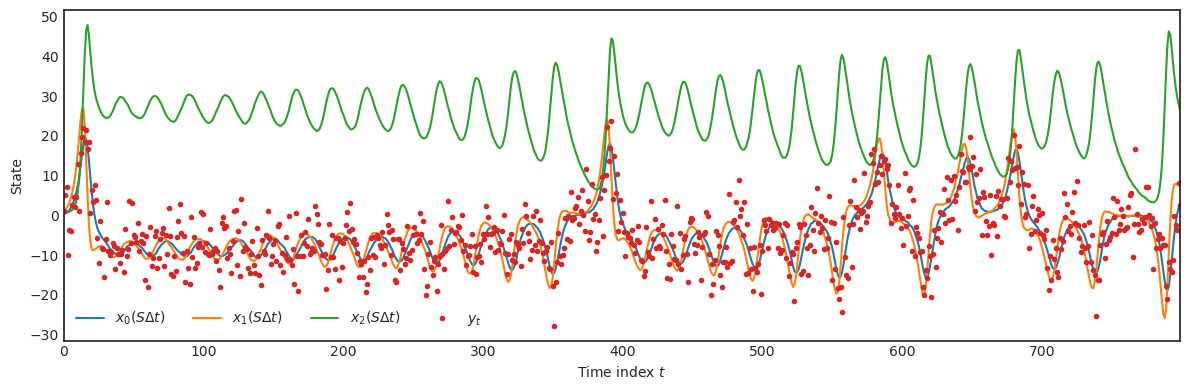

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(observation_time_indices, state_sequence)
ax.plot(observation_time_indices, observation_sequence, '.')
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
_ = ax.set_xlim(0, num_observation_time - 1)
ax.legend(['$x_0(S\Delta t)$', '$x_1(S\Delta t)$', '$x_2(S\Delta t)$', '$y_t$'], ncol=4)
fig.tight_layout()

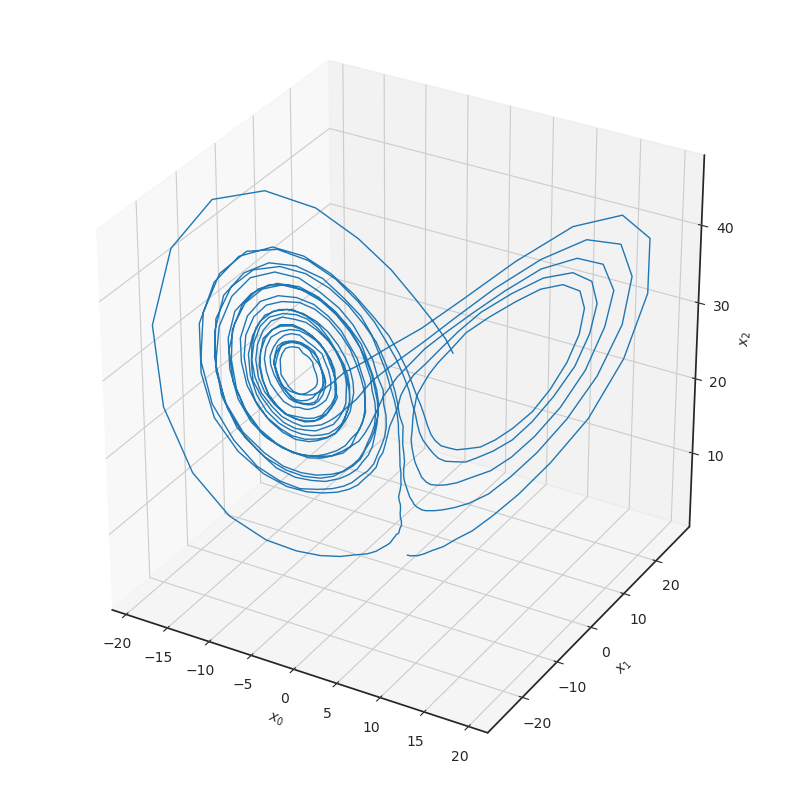

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.plot(*state_sequence.T, '-', lw=1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
fig.tight_layout()

### Infer state from observations

In [14]:
def plot_results(results, observation_time_indices, state_sequence=None, 
                 plot_particles=False, plot_region=True, 
                 particle_skip=2, trace_alpha=0.5):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 9))
    for i, ax in zip(range(3), axes):
        ax.plot(results['state_mean_sequence'][:, i], 'g-', lw=1, label='Est. mean')
        if plot_region:
            ax.fill_between(
                observation_time_indices,
                results['state_mean_sequence'][:, i] - 3 * results['state_std_sequence'][:, i],
                results['state_mean_sequence'][:, i] + 3 * results['state_std_sequence'][:, i],
                alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
            )
        if plot_particles:
            lines = ax.plot(
                observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, i], 
                'r-', lw=0.25, alpha=trace_alpha)
            lines[0].set_label('Particles')
        if state_sequence is not None:
            ax.plot(observation_time_indices, state_sequence[:, i], 'k--', label='Truth')
        ax.set_ylabel('$x_{0}$'.format(i))
        ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

In [15]:
from IPython.display import Image

### Kalman filter

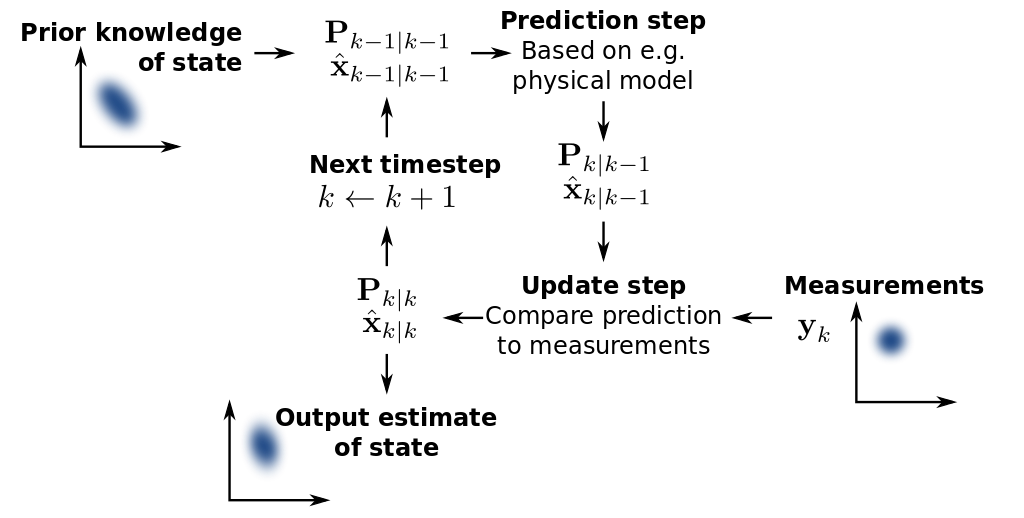

In [16]:
Image(filename='/opt/static/Basic_concept_of_Kalman_filtering.png') 

References:

1. Kalman, R. E. (1960). A new approach to linear filtering and prediction problems. Transactions of the ASME -- Journal of Basic Engineering, Series D, 82, pp. 35--45.

In [17]:
fkf = filters.FunctionKalmanFilter()

In [37]:
results_fkf = fkf.filter(
    model, observation_sequence, observation_time_indices, rng=rng)

Filtering: 100%|██████████|4000/4000 [00:01<00:00, 3003.08time-steps/s]

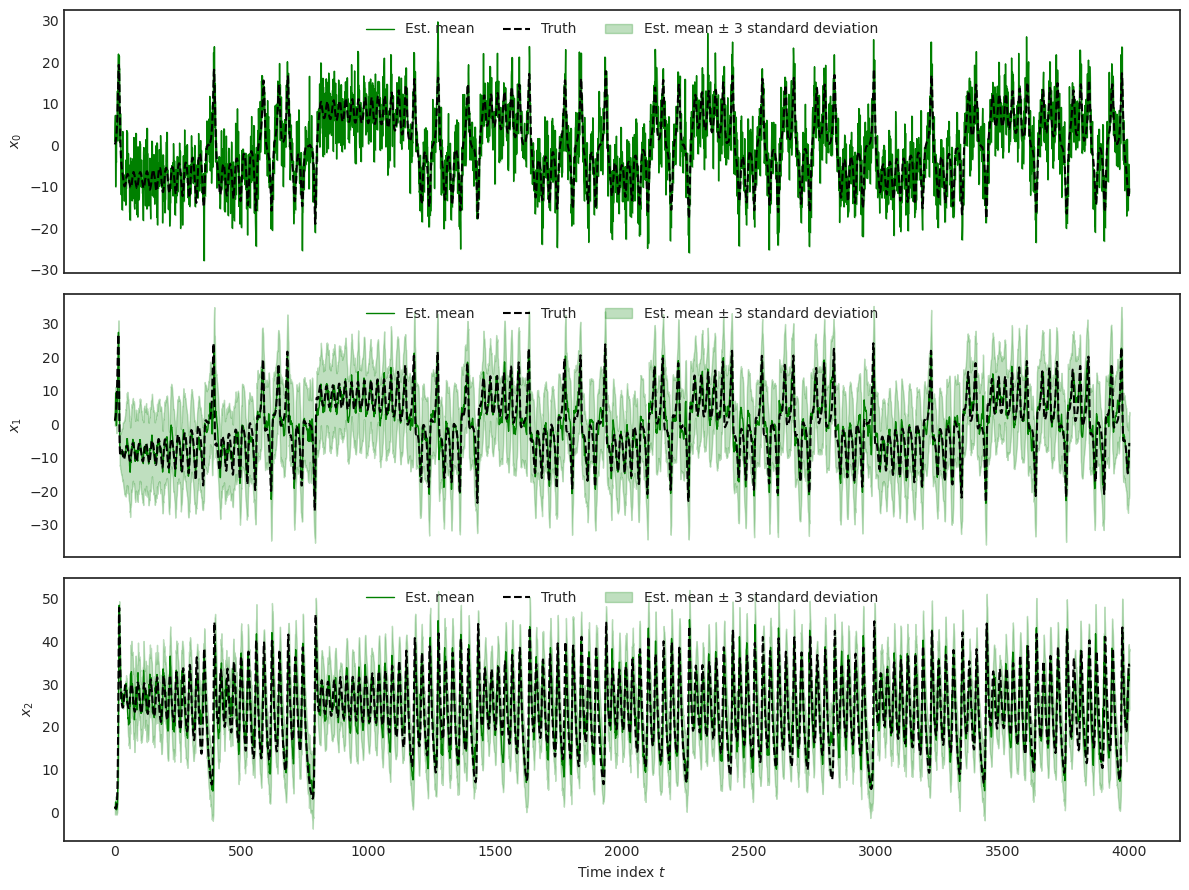

In [38]:
fig, axes = plot_results(results_fkf, observation_time_indices, state_sequence)

### Ensemble Kalman filter (perturbed observations)

Ensemble Kalman filter with perturbed observations.

The filtering distribution at each observation time index is approximated by alternating propagating an ensemble of state particles forward through time under the model dynamics and linearly transforming the ensemble according to a Monte Carlo estimate of the Kalman filter assimilation update due to the observations at the current time index. Here a 'perturbed observation' ensemble Kalman filter assimilation update is used with an observation particle sampled for each state particle from the conditional distribution on the observation given the state, and these observation particles as well as the original state particles used to approximate the covariance and mean statistics used in the Kalman update.

References:

Evensen, G. (1994). Sequential data assimilation with nonlinear quasi-geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research, 99 (C5), pp. 143--162

Burgers, G.,van Leeuwen, P. J. and Evensen, G. (1998). Analysis scheme in the ensemble Kalman filter. Monthly Weather Review, (126) pp 1719--1724.

In [20]:
enkf = filters.EnsembleKalmanFilter()

In [31]:
# Experiment with different values for num_particle
# How does the result change?
num_particle = ??

In [35]:
results_enkf = enkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=num_particle, rng=rng, return_particles=True)

Filtering: 100%|██████████|4000/4000 [00:02<00:00, 1818.53time-steps/s]

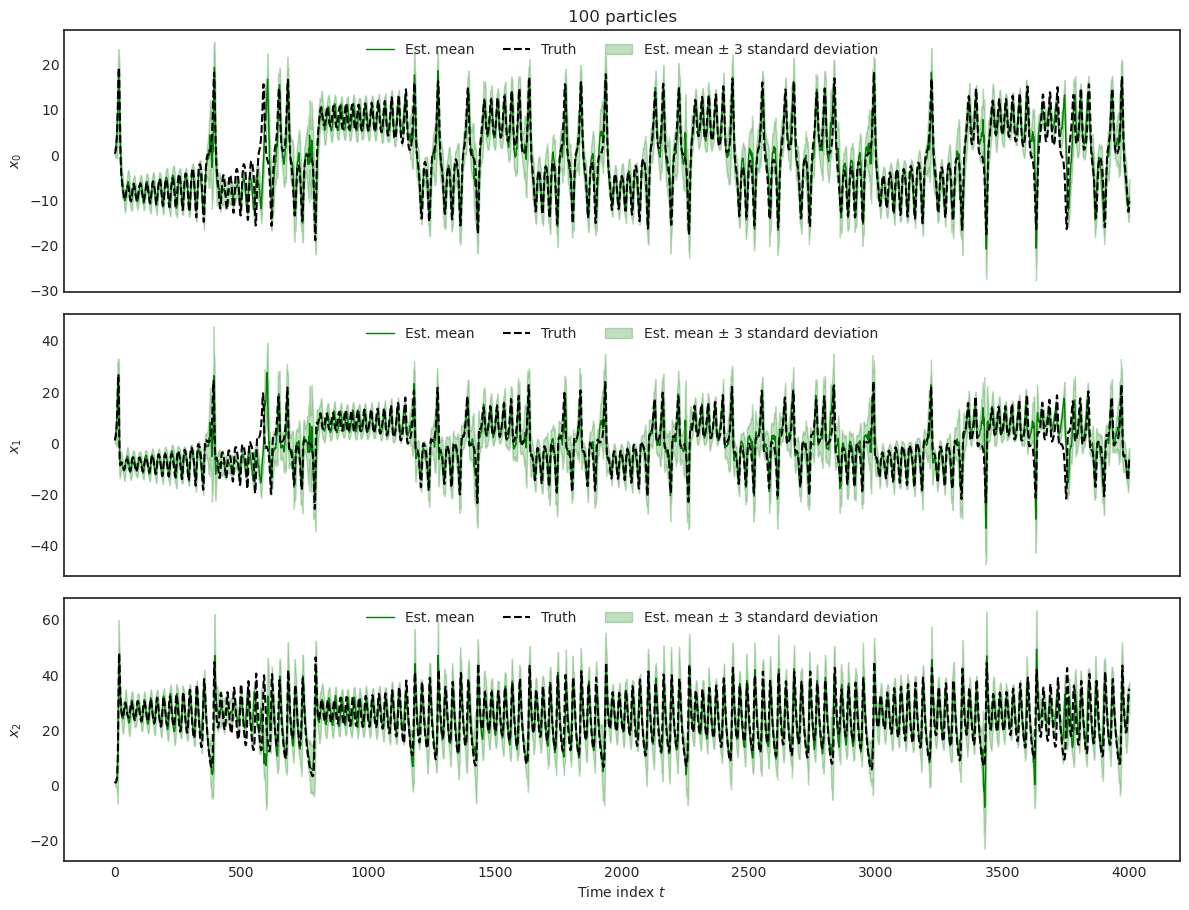

In [36]:
fig, axes = plot_results(results_enkf, observation_time_indices, state_sequence)
axes[0].set_title('{} particles'.format(num_particle));

### Ensemble Transform Kalman filter (deterministic square root)

Ensemble Kalman filter with deterministic matrix square root updates.

The filtering distribution at each observation time index is approximated by alternating propagating an ensemble of state particles forward through time under the model dynamics and linearly transforming the ensemble according to a Monte Carlo estimate of the Kalman filter assimilation update due to the observations at the current time index. Here a 'square-root' ensemble Kalman filter assimilation update is used, which requires that the model has Gaussian observation noise with a known covariance, but compared to the 'perturbed observation' variant avoids the additional variance associated with sampling pseudo-observations.

References:

1. Bishop, C. H. Etherton, B. J. and  Majumdar, S. J. (2001). Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects.Mon. Wea. Rev., 129, 420–436.
2. M. K. Tippett, J. L. Anderson, C. H. Bishop, T. M. Hamill, and J. S. Whitaker, Ensemble square root filters, Monthly Weather Review, 131 (2003), pp. 1485--1490.

In [23]:
etkf = filters.EnsembleTransformKalmanFilter()

In [ ]:
# Experiment with different values for num_particle
# How does the result change?
num_particle = ??

In [41]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=num_particle, rng=rng, return_particles=True)

Filtering: 100%|██████████|4000/4000 [00:02<00:00, 1599.10time-steps/s]

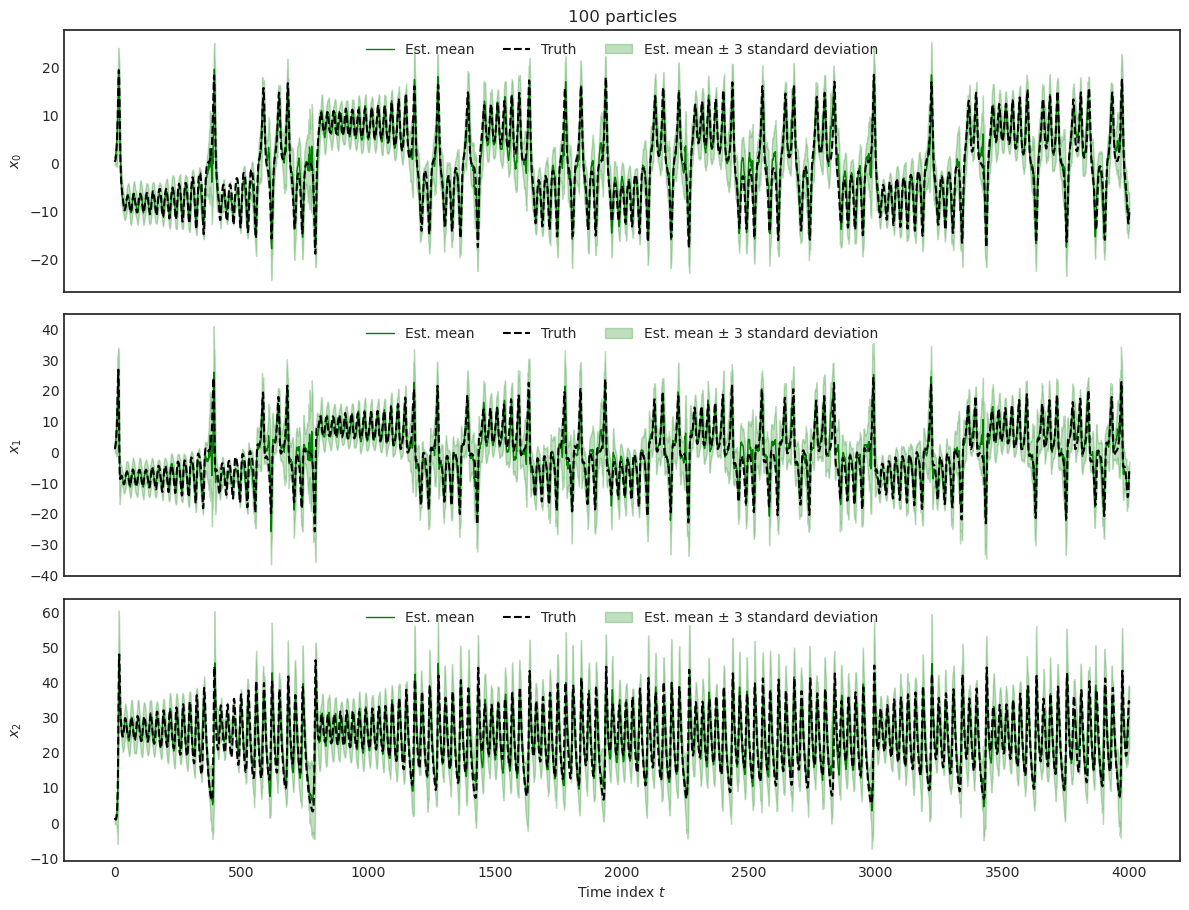

In [43]:
fig, axes = plot_results(results_etkf, observation_time_indices, state_sequence)
axes[0].set_title('{} particles'.format(num_particle));

TODO 3

Try different parameters for the model. Does it still exhibit chaotic properties? How do different filters adapt?

## Reservoir computing

Reservoir computing is a framework for computation derived from recurrent neural network theory that maps input signals into higher dimensional computational spaces through the dynamics of a fixed, non-linear system called a reservoir. After the input signal is fed into the reservoir, which is treated as a "black box," a simple readout mechanism is trained to read the state of the reservoir and map it to the desired output. The first key benefit of this framework is that training is performed only at the readout stage, as the reservoir dynamics are fixed. The second is that the computational power of naturally available systems, both classical and quantum mechanical, can be utilized to reduce the effective computational cost.

References:

1. Tanaka, Gouhei; Yamane, Toshiyuki; Héroux, Jean Benoit; Nakane, Ryosho; Kanazawa, Naoki; Takeda, Seiji; Numata, Hidetoshi; Nakano, Daiju; Hirose, Akira (2019). "Recent advances in physical reservoir computing: A review". Neural Networks. 115: 100–123. doi:10.1016/j.neunet.2019.03.005. ISSN 0893-6080. PMID 30981085.
2. Röhm, André; Lüdge, Kathy (2018-08-03). "Multiplexed networks: reservoir computing with virtual and real nodes". Journal of Physics Communications. 2 (8): 085007. Bibcode:2018JPhCo...2h5007R. doi:10.1088/2399-6528/aad56d. ISSN 2399-6528

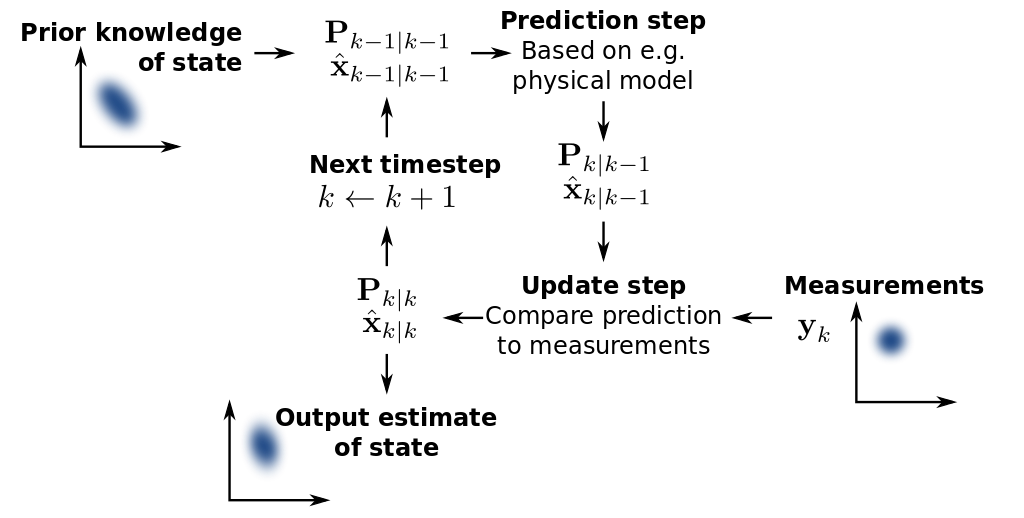

In [26]:
Image(filename='/opt/static/Basic_concept_of_Kalman_filtering.png') 

## Echo state network

The echo state network (ESN) is a type of reservoir computer that uses a recurrent neural network with a sparsely connected hidden layer (with typically 1% connectivity). The connectivity and weights of hidden neurons are fixed and randomly assigned. The weights of output neurons can be learned so that the network can produce or reproduce specific temporal patterns. The main interest of this network is that although its behaviour is non-linear, the only weights that are modified during training are for the synapses that connect the hidden neurons to output neurons. Thus, the error function is quadratic with respect to the parameter vector and can be differentiated easily to a linear system.

test error: 
0.20871214705952484


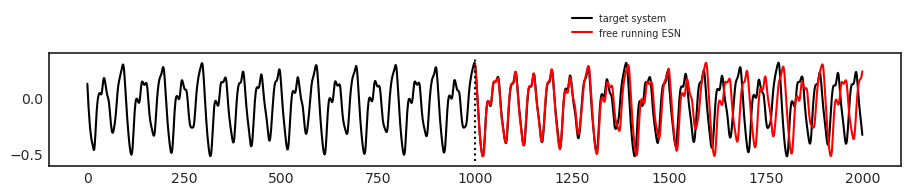

In [27]:
import sys
sys.path.append('/tmp/pyESN')
from pyESN import ESN

data = np.load('/tmp/pyESN/mackey_glass_t17.npy')
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)

trainlen = 1000
future = 1000
pred_training = esn.fit(np.ones(trainlen),data[:trainlen])

prediction = esn.predict(np.ones(future))
print("test error: \n"+str(np.sqrt(np.mean((prediction.flatten() - data[trainlen:trainlen+future])**2))))

plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),data[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')

In [28]:
num_observation_time = 4000
observation_time_indices = np.arange(num_observation_time)
seed = 1234
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|4000/4000 [00:00<00:00, 8918.57time-steps/s]

Text(0.5, 0.92, 'Lorenz Attractor')

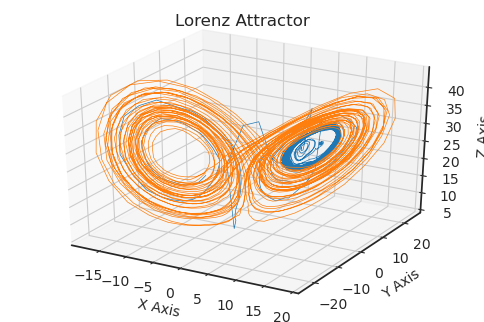

In [29]:
data = state_sequence
esn = ESN(n_inputs = 1,
          n_outputs = 3, #ex
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)

trainlen = 2000
future = 2000
pred_training = esn.fit(np.ones(trainlen),data[:trainlen])

prediction = esn.predict(np.ones(future))


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(prediction[:,0], prediction[:,1], prediction[:,2], lw=0.5)
ax.plot(data[future:,0], data[future:,1], data[future:,2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")